# Exploring the MNIST Digits Dataset

## Importing Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

import sys
!{sys.executable} -m pip install boto3

import boto3
import logging
from botocore.exceptions import ClientError
from botocore.client import Config

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

## Exploring Data

In [3]:
# check shape of the data

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


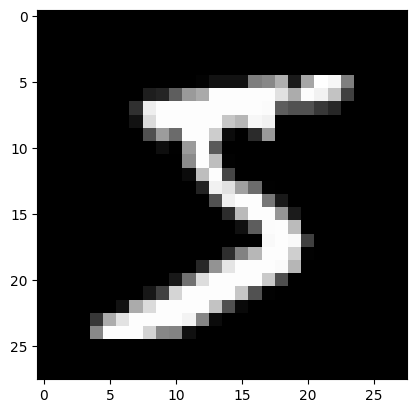

correct number: 5


In [4]:
# visualize single data instances

img_no = 0 #change the number to display other examples

first_number = x_train[img_no]
plt.imshow(first_number, cmap='gray') # visualize the numbers in gray mode
plt.show()
print(f"correct number: {y_train[img_no]}")

## Preparing Data & Splitting

In [5]:
# reshaping the data
# reshaping pixels in a 28x28px image with greyscale, canal = 1. This is needed for the Keras API
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# normalizing the data
# each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
x_train = x_train / 255
x_test = x_test / 255

print(f"train X shape: {x_train.shape}")
print(f"test X shape: {x_test.shape}")

train X shape: (60000, 28, 28, 1)
test X shape: (10000, 28, 28, 1)


In [6]:
#Uploading Data to the FlashBlade bucket. 

import os
FB_DATA_VIP_URL = "http://10.21.127.71" #URL with IP or hostname of your FlashBlade's data VIP

FB_S3_ACCESS_KEY = "PSFBSAZQJMLBOLBJPJKGGDPOKNBFJKNKEKCIBDBKC"
FB_S3_SECRET_KEY = "A634182A4ada951da+10d6/A0421BC11f17471eDMKE"

s3 = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)
    
fb_bucket = "mlpipeline5"
    
def create_bucket(bucket_name, region=None):
    # Create bucket
    try:
        if region is None:
            s3_client = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

create_bucket(fb_bucket)
    
def upload_files_to_s3(local_folder, bucket_name, s3_prefix=''):
    # Initialize the S3 client
    s3 = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)

    # Walk through the local folder and upload each file to the S3 bucket
    for root, _, files in os.walk(local_folder):
        for file in files:
            local_file_path = os.path.join(root, file)
            s3_key = os.path.join(s3_prefix, os.path.relpath(local_file_path, local_folder))
            # Upload the file to the S3 bucket
            s3.upload_file(local_file_path, bucket_name, s3_key)


upload_files_to_s3("mnist/",fb_bucket,"")    

for key in s3.list_objects(Bucket=fb_bucket)['Contents']:
    print(key['Key'])

mnist.npz


## Model Building

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax')) #output are 10 classes, numbers from 0-9

#show model summary - how it looks
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

2023-11-02 20:11:13.981459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-02 20:11:13.981517: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-02 20:11:13.981567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (digit-notebook-0): /proc/driver/nvidia/version does not exist
2023-11-02 20:11:13.981968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#compile the model - we want to have a multiple outcome
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [9]:
#fit the model and return the history while training
history = model.fit(
  x=x_train,
  y=y_train,
  epochs=1
)

2023-11-02 20:11:20.574905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-11-02 20:11:20.576090: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2294685000 Hz


1875/1875 [==============================] - 198s 105ms/step - loss: 0.2238 - accuracy: 0.9307


## Model Evaluation

In [10]:
keras.models.save_model(model,"models/detect-digits")

2023-11-02 20:14:44.670636: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/detect-digits/assets


In [11]:
# Let's upload the model files to FlashBlade bucketimport os

import os
FB_DATA_VIP_URL = "http://10.21.127.71" #URL with IP or hostname of your FlashBlade's data VIP

FB_S3_ACCESS_KEY = "PSFBSAZQJMLBOLBJPJKGGDPOKNBFJKNKEKCIBDBKC"
FB_S3_SECRET_KEY = "A634182A4ada951da+10d6/A0421BC11f17471eDMKE"

s3 = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)
    
fb_bucket = "mlpipeline6"

def create_bucket(bucket_name, region=None):
    # Create bucket
    try:
        if region is None:
            s3_client = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except ClientError as e:
        logging.error(e)
        return False
    return True

create_bucket(fb_bucket)
        
def upload_files_to_s3(local_folder, bucket_name, s3_prefix=''):
    # Initialize the S3 client
    s3 = boto3.client('s3', aws_access_key_id=FB_S3_ACCESS_KEY, aws_secret_access_key=FB_S3_SECRET_KEY, endpoint_url=FB_DATA_VIP_URL)

    # Walk through the local folder and upload each file to the S3 bucket
    for root, _, files in os.walk(local_folder):
        for file in files:
            local_file_path = os.path.join(root, file)
            s3_key = os.path.join(s3_prefix, os.path.relpath(local_file_path, local_folder))
            # Upload the file to the S3 bucket
            s3.upload_file(local_file_path, bucket_name, s3_key)


upload_files_to_s3("models/detect-digits",fb_bucket,"models/detect-digits")            

for key in s3.list_objects(Bucket=fb_bucket)['Contents']:
    print(key['Key'])

models/detect-digits/keras_metadata.pb
models/detect-digits/saved_model.pb
models/detect-digits/variables/variables.data-00000-of-00001
models/detect-digits/variables/variables.index


In [12]:
# Test the model against the test dataset
# Returns the loss value & metrics values for the model in test mode.
model_loss, model_accuracy = model.evaluate(x=x_test,y=y_test)

313/313 [==============================] - 9s 27ms/step - loss: 0.0865 - accuracy: 0.9735


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

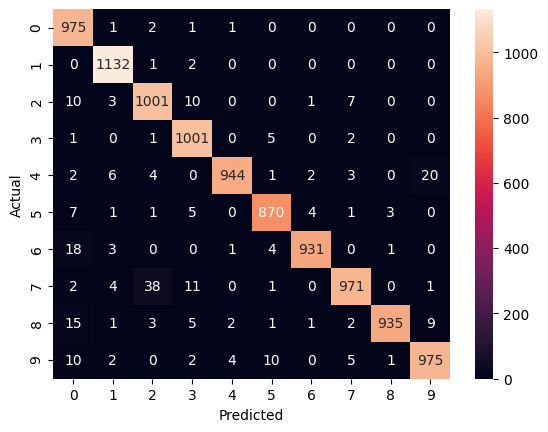

In [13]:
# Confusion Matrix

# Generates output predictions for the input samples.
test_predictions = model.predict(x=x_test)

# Returns the indices of the maximum values along an axis.
test_predictions = np.argmax(test_predictions,axis=1) # the prediction outputs 10 values, we take the index number of the highest value, which is the prediction of the model

# generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_test,predictions=test_predictions)

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
h = sns.heatmap(confusion_matrix,annot=True,fmt='d')
h.set(xlabel='Predicted', ylabel='Actual')